# Large-Scale Stochastic Variational GP Regression in 1D (w/ KISS-GP)

## Introduction

This example shows how to perform GP regression, but using **variational inference** rather than exact inference. There are a few cases where variational inference may be prefereable:

1) If you have lots of data, and want to perform **stochastic optimization**

2) If you have a model where you want to use other variational distributions

KISS-GP with SVI was introduced in:
https://papers.nips.cc/paper/6426-stochastic-variational-deep-kernel-learning.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

/home/gpleiss/anaconda3/envs/gpytorch/lib/python3.7/site-packages/matplotlib/__init__.py:999: UserWarning: Duplicate key in file "/home/gpleiss/.dotfiles/matplotlib/matplotlibrc", line #57
  (fname, cnt))


In [2]:
# Create a training set
# We're going to learn a sine function
train_x = torch.linspace(0, 1, 1000)
train_y = torch.sin(train_x * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2

## Performing SGD - the dataloader

Because we want to do stochastic optimization, we have to put the dataset in a pytorch **DataLoader**.
This creates easy minibatches of the data

In [3]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## The model

This is pretty similar to a normal regression model, except now we're using a `gpytorch.models.GridInducingVariationalGP` instead of a `gpytorch.models.ExactGP`.

Any of the variational models would work. We're using the `GridInducingVariationalGP` because we have many data points, but only 1 dimensional data.

Similar to exact regression, we use a `GaussianLikelihood`.

In [4]:
class GPRegressionModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPRegressionModel, self).__init__(grid_size=20, grid_bounds=[(-0.05, 1.05)])
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                    math.exp(-3), math.exp(6), sigma=0.1, transform=torch.exp
                )
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
model = GPRegressionModel()
likelihood = gpytorch.likelihoods.GaussianLikelihood()

## The training loop

This training loop will use **stochastic optimization** rather than batch optimization

In [5]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object
# We're using the VariationalMarginalLogLikelihood object
mll = gpytorch.mlls.VariationalMarginalLogLikelihood(likelihood, model, num_data=train_y.numel())

# The training loop
def train(n_epochs=20):
    # We use a Learning rate scheduler from PyTorch to lower the learning rate during optimization
    # We're going to drop the learning rate by 1/10 after 3/4 of training
    # This helps the model converge to a minimum
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.75 * n_epochs], gamma=0.1)
    
    for i in range(n_epochs):
        scheduler.step()
        
        # Within each iteration, we will go over each minibatch of data
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            
            # The actual optimization step
            loss.backward()
            optimizer.step()
            
        print('Epoch %d/%d - Loss: %.3f' % (i + 1, n_epochs, loss.item()))
            
%time train()

Epoch 1/20 - Loss: 1.485
Epoch 2/20 - Loss: 1.314
Epoch 3/20 - Loss: 1.203
Epoch 4/20 - Loss: 1.070
Epoch 5/20 - Loss: 1.028
Epoch 6/20 - Loss: 1.030
Epoch 7/20 - Loss: 0.752
Epoch 8/20 - Loss: 0.728
Epoch 9/20 - Loss: 0.479
Epoch 10/20 - Loss: 0.355
Epoch 11/20 - Loss: 0.216
Epoch 12/20 - Loss: 0.124
Epoch 13/20 - Loss: 0.135
Epoch 14/20 - Loss: 0.068
Epoch 15/20 - Loss: -0.013
Epoch 16/20 - Loss: -0.001
Epoch 17/20 - Loss: 0.053
Epoch 18/20 - Loss: 0.015
Epoch 19/20 - Loss: -0.059
Epoch 20/20 - Loss: -0.004
CPU times: user 19.6 s, sys: 852 ms, total: 20.5 s
Wall time: 5.11 s


## Testing the model

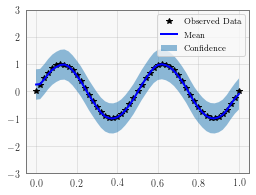

In [6]:
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 1, 51)
test_y = torch.sin(test_x * (4 * math.pi))
with torch.no_grad():
    observed_pred = likelihood(model(test_x))

lower, upper = observed_pred.confidence_region()
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(test_x.detach().cpu().numpy(), test_y.detach().cpu().numpy(), 'k*')
ax.plot(test_x.detach().cpu().numpy(), observed_pred.mean.detach().cpu().numpy(), 'b')
ax.fill_between(test_x.detach().cpu().numpy(), lower.detach().cpu().numpy(), upper.detach().cpu().numpy(), alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])